In [1]:
import tensorflow as tf
from keras import Model, regularizers, activations, initializers
from keras.layers import Input, Dense, LSTM, Add, RNN, SimpleRNN
from keras.optimizers import Adam
from keras import backend as K

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
# Toy dataset
ll = np.linspace(-1,1,60)
xx,yy = np.meshgrid(ll,ll)

zz = -np.cos(4 * (xx**2 + yy**2))
# zz = np.fmax(np.fmin(xx**2 + yy**2, (2*xx-1)**2  + (2*yy-1)**2 - 2), -(2*xx+1)**2  - (2*yy+1)**2 + 4)
# zz = xx**2 * (4 - 2.1 * xx**2 + xx**4 / 3) - 4 * yy**2 * (1 - yy**2) + xx * yy

inps = np.stack([xx.reshape(-1,1), yy.reshape(-1,1)], axis=-1)
inps_ = np.concatenate([inps,-inps], axis=-1)
targs = zz.reshape(-1,1,1)

train_inps,test_inps,train_targs,test_targs = train_test_split(inps_, targs, test_size=0.3)

In [17]:
# ICLSTM
class MyICLSTMCell(tf.keras.layers.Layer):

    def __init__(self, units, **kwargs):
        self.units = units
        self.state_size = [self.units, self.units]
        super(MyICLSTMCell, self).__init__(**kwargs)

    def build(self, input_shape):
        self.Wi = self.add_weight(shape=(input_shape[-1], self.units),
                                      initializer=initializers.RandomNormal(mean=0.0, stddev=0.01),
                                      name='Wi',
                                      constraint=tf.keras.constraints.NonNeg(),
                                      trainable=True)
        self.Ui = self.add_weight(shape=(self.units, self.units),
                                      initializer=initializers.Orthogonal(0.1),
                                      name='Ui',
                                      constraint=tf.keras.constraints.NonNeg(),
                                      trainable=True)
        self.DWi = self.add_weight(shape=(self.units,),
                                      initializer=initializers.RandomUniform(minval=0, maxval=1),
                                      name='DWi',
                                      constraint=tf.keras.constraints.NonNeg(),
                                      trainable=True)
        self.DUi = self.add_weight(shape=(self.units,),
                                      initializer=initializers.RandomUniform(minval=0, maxval=1),
                                      name='DUi',
                                      constraint=tf.keras.constraints.NonNeg(),
                                      trainable=True)
        self.bi = self.add_weight(shape=(self.units,), initializer='zeros', name='bi', trainable=True)

        self.DWf = self.add_weight(shape=(self.units,),
                                      initializer=initializers.RandomUniform(minval=0, maxval=1),
                                      name='DWf',
                                      constraint=tf.keras.constraints.NonNeg(),
                                      trainable=True)
        self.DUf = self.add_weight(shape=(self.units,),
                                      initializer=initializers.RandomUniform(minval=0, maxval=1),
                                      name='DUf',
                                      constraint=tf.keras.constraints.NonNeg(),
                                      trainable=True)
        self.bf = self.add_weight(shape=(self.units,), initializer='zeros', name='bf', trainable=True)

        self.DWo = self.add_weight(shape=(self.units,),
                                      initializer=initializers.RandomUniform(minval=0, maxval=1),
                                      name='DWo',
                                      constraint=tf.keras.constraints.NonNeg(),
                                      trainable=True)
        self.DUo = self.add_weight(shape=(self.units,),
                                      initializer=initializers.RandomUniform(minval=0, maxval=1),
                                      name='DUo',
                                      constraint=tf.keras.constraints.NonNeg(),
                                      trainable=True)
        self.bo = self.add_weight(shape=(self.units,), initializer='zeros', name='bo', trainable=True)

        self.DWc = self.add_weight(shape=(self.units,),
                                      initializer=initializers.RandomUniform(minval=0, maxval=1),
                                      name='DWc',
                                      constraint=tf.keras.constraints.NonNeg(),
                                      trainable=True)
        self.DUc = self.add_weight(shape=(self.units,),
                                      initializer=initializers.RandomUniform(minval=0, maxval=1),
                                      name='DUc',
                                      constraint=tf.keras.constraints.NonNeg(),
                                      trainable=True)
        self.bc = self.add_weight(shape=(self.units,), initializer='zeros', name='bc', trainable=True)

        self.built = True

    def call(self, inputs, states):
        h_tm1 = states[0]  # previous hidden state
        c_tm1 = states[1]  # previous cell state

        # scaling version
        i = tf.nn.relu(self.DWi * K.dot(inputs, self.Wi) + self.DUi * K.dot(h_tm1, self.Ui) + self.bi)
        f = tf.nn.relu(self.DWf * K.dot(inputs, self.Wi) + self.DUf * K.dot(h_tm1, self.Ui) + self.bf)
        o = tf.nn.relu(self.DWo * K.dot(inputs, self.Wi) + self.DUo * K.dot(h_tm1, self.Ui) + self.bo)
        c = tf.nn.relu(self.DWc * K.dot(inputs, self.Wi) + self.DUc * K.dot(h_tm1, self.Ui) + self.bc)

        # # non-scaling version
        # i = tf.nn.relu(K.dot(inputs, self.Wi) + K.dot(h_tm1, self.Ui) + self.bi)
        # f = tf.nn.relu(K.dot(inputs, self.Wi) + K.dot(h_tm1, self.Ui) + self.bf)
        # o = tf.nn.relu(K.dot(inputs, self.Wi) + K.dot(h_tm1, self.Ui) + self.bo)
        # c = tf.nn.relu(K.dot(inputs, self.Wi) + K.dot(h_tm1, self.Ui) + self.bc)

        new_c = f * c_tm1 + i * c
        new_h = o * tf.nn.relu(new_c)

        return new_h, [new_h, new_c]

    def get_config(self):
        config = super(MyICLSTMCell, self).get_config()
        config.update({"units": self.units})
        return config

input = Input(shape=(train_inps.shape[1],train_inps.shape[2]))
x_skip = input
x = RNN(MyICLSTMCell(units=64),return_sequences=True)(input)
x = Dense(train_inps.shape[2], activation='relu', kernel_constraint=tf.keras.constraints.NonNeg())(x)
x = Add()([x, x_skip])
x = RNN(MyICLSTMCell(units=64),return_sequences=True)(x)
x = Dense(train_inps.shape[2], activation='relu', kernel_constraint=tf.keras.constraints.NonNeg())(x)
x = Add()([x, x_skip])
x = Dense(1, activation='linear', kernel_constraint=tf.keras.constraints.NonNeg())(x)
model = Model(input, x)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError()])
log = model.fit(train_inps, train_targs, epochs=500, batch_size=64, validation_split=0.25, verbose=2)
model.summary()

Epoch 1/500
30/30 - 11s - loss: 0.9555 - mean_squared_error: 0.9555 - val_loss: 0.8073 - val_mean_squared_error: 0.8073 - 11s/epoch - 354ms/step
Epoch 2/500
30/30 - 0s - loss: 0.8741 - mean_squared_error: 0.8741 - val_loss: 0.7583 - val_mean_squared_error: 0.7583 - 443ms/epoch - 15ms/step
Epoch 3/500
30/30 - 0s - loss: 0.8195 - mean_squared_error: 0.8195 - val_loss: 0.7157 - val_mean_squared_error: 0.7157 - 466ms/epoch - 16ms/step
Epoch 4/500
30/30 - 0s - loss: 0.7714 - mean_squared_error: 0.7714 - val_loss: 0.6767 - val_mean_squared_error: 0.6767 - 458ms/epoch - 15ms/step
Epoch 5/500
30/30 - 0s - loss: 0.7181 - mean_squared_error: 0.7181 - val_loss: 0.6219 - val_mean_squared_error: 0.6219 - 246ms/epoch - 8ms/step
Epoch 6/500
30/30 - 0s - loss: 0.6270 - mean_squared_error: 0.6270 - val_loss: 0.5324 - val_mean_squared_error: 0.5324 - 273ms/epoch - 9ms/step
Epoch 7/500
30/30 - 0s - loss: 0.5496 - mean_squared_error: 0.5496 - val_loss: 0.5020 - val_mean_squared_error: 0.5020 - 281ms/epoch

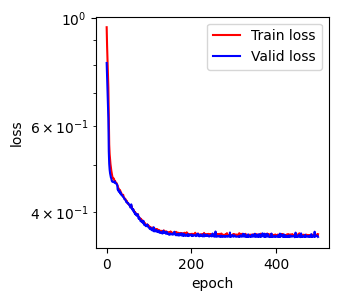

In [18]:
fig,ax = plt.subplots(figsize=(3,3))
ax.plot(log.history['loss'], 'r', label='Train loss')
ax.plot(log.history['val_loss'], 'b', label='Valid loss')
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_yscale('log')
ax.legend()

In [19]:
preds = model.predict(tf.convert_to_tensor(inps_, np.float32)).reshape((60,60))

113/113 [==============================] - 1s 3ms/step


Val MSE:  0.3556210398674011


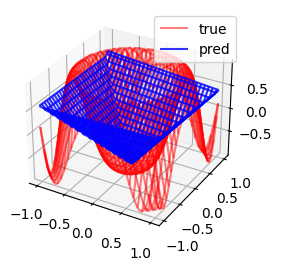

In [20]:
print("Val MSE: ", log.history['val_loss'][-1])

# Plot 3D
plt.close(fig='all')
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111, projection='3d')

ax.plot_wireframe(xx, yy, zz,    color='r', alpha=0.5, label='true')
ax.plot_wireframe(xx, yy, preds, color='b', alpha=0.8, label='pred')
ax.legend();

Epoch 1/1000
30/30 - 3s - loss: 0.5127 - mean_squared_error: 0.5127 - val_loss: 0.5159 - val_mean_squared_error: 0.5159 - 3s/epoch - 105ms/step
Epoch 2/1000
30/30 - 0s - loss: 0.5032 - mean_squared_error: 0.5032 - val_loss: 0.5143 - val_mean_squared_error: 0.5143 - 224ms/epoch - 7ms/step
Epoch 3/1000
30/30 - 0s - loss: 0.5010 - mean_squared_error: 0.5010 - val_loss: 0.5111 - val_mean_squared_error: 0.5111 - 243ms/epoch - 8ms/step
Epoch 4/1000
30/30 - 0s - loss: 0.4972 - mean_squared_error: 0.4972 - val_loss: 0.5057 - val_mean_squared_error: 0.5057 - 202ms/epoch - 7ms/step
Epoch 5/1000
30/30 - 0s - loss: 0.4883 - mean_squared_error: 0.4883 - val_loss: 0.4989 - val_mean_squared_error: 0.4989 - 197ms/epoch - 7ms/step
Epoch 6/1000
30/30 - 0s - loss: 0.4800 - mean_squared_error: 0.4800 - val_loss: 0.4880 - val_mean_squared_error: 0.4880 - 203ms/epoch - 7ms/step
Epoch 7/1000
30/30 - 0s - loss: 0.4681 - mean_squared_error: 0.4681 - val_loss: 0.4744 - val_mean_squared_error: 0.4744 - 193ms/epo

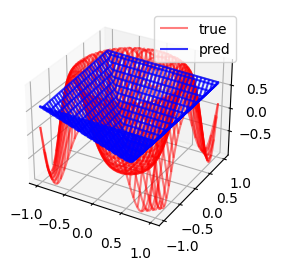

In [77]:
# simple ICRNN
nh = 64
input = Input(shape=(train_inps.shape[1],train_inps.shape[2]))
x_skip = input
x = SimpleRNN(nh, activation='relu',
         kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.01),
         recurrent_initializer=initializers.Orthogonal(0.1),
         return_sequences=True,
         kernel_constraint=tf.keras.constraints.NonNeg(),
         recurrent_constraint=tf.keras.constraints.NonNeg()
         )(input)
x = Dense(train_inps.shape[2], activation='relu',
          kernel_constraint=tf.keras.constraints.NonNeg()
          )(x)
x = Add()([x, x_skip])
x = SimpleRNN(nh, activation='relu',
         kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.01),
         recurrent_initializer=initializers.Orthogonal(0.1),
         return_sequences=True,
         kernel_constraint=tf.keras.constraints.NonNeg(),
         recurrent_constraint=tf.keras.constraints.NonNeg()
         )(x)
x = Dense(train_inps.shape[2], activation='relu',
          kernel_constraint=tf.keras.constraints.NonNeg()
          )(x)
x = Add()([x, x_skip])
x = Dense(1, activation='linear',
          kernel_constraint=tf.keras.constraints.NonNeg()
          )(x)
model = Model(input, x)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError()])
log = model.fit(train_inps, train_targs, epochs=500, batch_size=64, validation_split=0.25, verbose=2)
model.summary()

fig,ax = plt.subplots(figsize=(3,3))
ax.plot(log.history['loss'], 'r', label='Train loss')
ax.plot(log.history['val_loss'], 'b', label='Valid loss')
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_yscale('log')
ax.legend()

preds = model.predict(tf.convert_to_tensor(inps_, np.float32)).reshape((60,60))

# Plot 3D
plt.close(fig='all')
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111, projection='3d')

ax.plot_wireframe(xx, yy, zz,    color='r', alpha=0.5, label='true')
ax.plot_wireframe(xx, yy, preds, color='b', alpha=0.8, label='pred')
ax.legend();

Epoch 1/500
30/30 - 4s - loss: 0.4697 - mean_squared_error: 0.4697 - val_loss: 0.4629 - val_mean_squared_error: 0.4629 - 4s/epoch - 136ms/step
Epoch 2/500
30/30 - 0s - loss: 0.4592 - mean_squared_error: 0.4592 - val_loss: 0.4506 - val_mean_squared_error: 0.4506 - 169ms/epoch - 6ms/step
Epoch 3/500
30/30 - 0s - loss: 0.4530 - mean_squared_error: 0.4530 - val_loss: 0.4441 - val_mean_squared_error: 0.4441 - 187ms/epoch - 6ms/step
Epoch 4/500
30/30 - 0s - loss: 0.4497 - mean_squared_error: 0.4497 - val_loss: 0.4469 - val_mean_squared_error: 0.4469 - 166ms/epoch - 6ms/step
Epoch 5/500
30/30 - 0s - loss: 0.4464 - mean_squared_error: 0.4464 - val_loss: 0.4458 - val_mean_squared_error: 0.4458 - 167ms/epoch - 6ms/step
Epoch 6/500
30/30 - 0s - loss: 0.4387 - mean_squared_error: 0.4387 - val_loss: 0.4336 - val_mean_squared_error: 0.4336 - 169ms/epoch - 6ms/step
Epoch 7/500
30/30 - 0s - loss: 0.4364 - mean_squared_error: 0.4364 - val_loss: 0.4328 - val_mean_squared_error: 0.4328 - 209ms/epoch - 7m

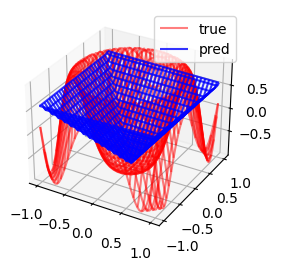

In [21]:
# ICRNN
class MyRNNCell(tf.keras.layers.Layer):

    def __init__(self, units, input_shape_custom, **kwargs):
        self.units = units
        self.input_shape_custom = input_shape_custom
        self.state_size = [tf.TensorShape([units]), tf.TensorShape([input_shape_custom])]
        super(MyRNNCell, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                      initializer='uniform',
                                      name='kernel',
                                      constraint=tf.keras.constraints.NonNeg(),
                                      trainable=True)
        self.recurrent_kernel = self.add_weight(shape=(self.units, self.units),
                                                initializer='uniform',
                                                name='recurrent_kernel',
                                                constraint=tf.keras.constraints.NonNeg(),
                                                trainable=True)
        self.D1 = self.add_weight(shape=(self.units, self.units),
                                 initializer='uniform',
                                 name='D1',
                                 constraint=tf.keras.constraints.NonNeg(),
                                 trainable=True)
        self.D2 = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='uniform',
                                 name='D2',
                                 constraint=tf.keras.constraints.NonNeg(),
                                 trainable=True)
        self.D3 = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='uniform',
                                 name='D3',
                                 constraint=tf.keras.constraints.NonNeg(),
                                 trainable=True)
        self.V = self.add_weight(shape=(self.units, self.units),
                                 initializer='uniform',
                                 name='V',
                                 constraint=tf.keras.constraints.NonNeg(),
                                 trainable=True)
        self.built = True

    def call(self, inputs, states):
        # ICRNN
        prev_h, prev_input = states
        h = K.dot(inputs, self.kernel) + K.dot(prev_h, self.recurrent_kernel) + K.dot(prev_input, self.D2)
        h = tf.nn.relu(h)
        y = K.dot(h, self.V) + K.dot(prev_h, self.D1) + K.dot(inputs, self.D3)
        y = tf.nn.relu(y)
        return y, [h, inputs]

    def get_config(self):
        config = super(MyRNNCell, self).get_config()
        config.update({"units": self.units, "input_shape_custom": self.input_shape_custom})
        return config

# simple ICRNN
input = Input(shape=(train_inps.shape[1],train_inps.shape[2]))
x_skip = input
x = RNN(MyRNNCell(units=64, input_shape_custom=train_inps.shape[2]),return_sequences=True)(input)
x = RNN(MyRNNCell(units=64, input_shape_custom=64),return_sequences=True)(x)
x = Dense(1, activation='linear', kernel_constraint=tf.keras.constraints.NonNeg())(x)
model = Model(input, x)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError()])
log = model.fit(train_inps, train_targs, epochs=500, batch_size=64, validation_split=0.25, verbose=2)
model.summary()

fig,ax = plt.subplots(figsize=(3,3))
ax.plot(log.history['loss'], 'r', label='Train loss')
ax.plot(log.history['val_loss'], 'b', label='Valid loss')
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_yscale('log')
ax.legend()

preds = model.predict(tf.convert_to_tensor(inps_, np.float32)).reshape((60,60))

# Plot 3D
plt.close(fig='all')
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111, projection='3d')

ax.plot_wireframe(xx, yy, zz,    color='r', alpha=0.5, label='true')
ax.plot_wireframe(xx, yy, preds, color='b', alpha=0.8, label='pred')
ax.legend();